In [1]:
# !pip install stellargraph[demos]
# !pip install tf-nightly

In [1]:
import stellargraph as sg
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from stellargraph.layer import GCN_LSTM

import datetime
import random
import pandas as pd

2022-02-16 21:56:45.652342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 21:56:45.652545: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-16 21:56:54.628187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-16 21:56:54.628398: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 21:56:54.628533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-02-16 21:56:54.629878: I tensorflow/core/platform/cpu_fe

In [2]:
def datapreparation(datafile):
    n_lat_grid = 100
    n_long_grid = 100
    hr_start, hr_end = 540, 660
    
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    df.dateTime = pd.to_datetime(df.dateTime)

    print(len(df))
    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    print(len(df))

    # rounding @15min
    df.dateTime = df.dateTime.dt.round('15min')
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=hr_start) & (df.dateTime<=hr_end)]

    # only PM2_5
    df = df[['dateTime','lat','long','pm2_5']]

    # TODO: Add buffer and consider train-data for range
    lat_range = {'min': df.lat.min(), 'max': df.lat.max()}
    long_range = {'min': df.long.min(), 'max': df.long.max()}

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)
    del df['lat']
    del df['long']


    grid = {}
    count = 0
    # projecting it onto grid numbered from 0 to N.
    for i,row in df.iterrows():
        if(not f"{int(row.lat_grid)} {int(row.long_grid)}" in grid):
            grid[f"{int(row.lat_grid)} {int(row.long_grid)}"] = count
            df.at[i,'grid'] = count
            count += 1
        else:
            df.at[i,'grid'] = grid[f"{int(row.lat_grid)} {int(row.long_grid)}"] 
    print(count)
    adj = np.zeros((count, count))       # N x N : adjacency matrix

    for i,row in df.iterrows():   
        if(f"{int(row.lat_grid + 1)} {int(row.long_grid)}" in grid):
            adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid + 1)} {int(row.long_grid)}"]] = 1   # added edge from current grid to neighbours
        if(f"{int(row.lat_grid)} {int(row.long_grid + 1)}" in grid):
            adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid + 1)}"]] = 1
        if(f"{int(row.lat_grid - 1)} {int(row.long_grid)}" in grid):
            adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid - 1)} {int(row.long_grid)}"]] = 1
        if(f"{int(row.lat_grid)} {int(row.long_grid - 1)}" in grid):
            adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid - 1)}"]] = 1

        if(f"{int(row.lat_grid + 1)} {int(row.long_grid)}" in grid):
            adj[grid[f"{int(row.lat_grid + 1)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1   # added edge from neighbours to current grid
        if(f"{int(row.lat_grid)} {int(row.long_grid + 1)}" in grid):
            adj[grid[f"{int(row.lat_grid)} {int(row.long_grid + 1)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1
        if(f"{int(row.lat_grid - 1)} {int(row.long_grid)}" in grid):
            adj[grid[f"{int(row.lat_grid - 1)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1
        if(f"{int(row.lat_grid)} {int(row.long_grid - 1)}" in grid):
            adj[grid[f"{int(row.lat_grid)} {int(row.long_grid - 1)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1

        adj[grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]][grid[f"{int(row.lat_grid)} {int(row.long_grid)}"]] = 1          # added self edges (empirically performs better in case of GCN)
        
    del df['lat_grid']
    del df['long_grid']

    df = df.pivot_table(index='grid', columns = 'dateTime', aggfunc='mean')['pm2_5']
    df = df.fillna(0)
    return df, adj

In [3]:

df, sensor_dist_adj= datapreparation('2021-01-15_all.csv')

178433
178432
382


In [4]:
df

dateTime,540,555,570,585,600,615,630,645,660
grid,,,,,,,,,
0.0,427.000000,0.000000,0.000000,513.678571,0.000000,0.000000,0.0,0.000000,282.617647
1.0,552.170732,404.078125,0.000000,493.647059,434.170213,447.545455,0.0,0.000000,388.125000
2.0,635.285714,0.000000,622.666667,449.444444,0.000000,376.250000,0.0,360.333333,320.000000
3.0,547.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4.0,454.452381,497.711864,383.094527,446.500000,488.769231,408.988827,395.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
377.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,367.500000
378.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,381.500000
379.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,383.000000


In [5]:
def train_test_split(data, train_portion):
    grid_len = data.shape[0]
    train_size = int(grid_len * train_portion)
    test_size = int(grid_len * (1-train_portion))
    test_grid_indices = random.sample(list(data.index), test_size)
    train_data = data.copy()
    train_data.loc[test_grid_indices, :] = 0
#     train_data = train_data.reindex(list(range(0, n_grid_points)),fill_value=0)
    train_data = np.array(train_data)

    test_data = data.loc[test_grid_indices, :] 
    test_data = test_data.reindex(list(range(0, grid_len)),fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [6]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [7]:
def sequence_data_preparation(seq_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []
#     seq_len = train_data.shape[1]

    for i in range(train_data.shape[1] - int(seq_len - 1)):
        a = train_data[:, i : i + seq_len]
        trainX.append(a)
        trainY.append(a.mean(axis = 1))

    for i in range(test_data.shape[1] - int(seq_len - 1)):
        b = test_data[:, i : i + seq_len]
        testX.append(b)
        testY.append(b.mean(axis = 1))

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [8]:
def prepare_train_data(df, train_portion = 0.8):
    train_data, test_data = train_test_split(df, train_portion)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

In [9]:
def my_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    mask = tf.sign(y_true)
    y_pred = y_pred*(mask)
    loss = mse(tf.reshape(y_true,(-1,)),tf.reshape(y_pred,(-1,)))
#     print(loss)
    return loss

In [37]:
def forecasting(trainX, trainY, testX, testY, train_data):
    cb = TimingCallback()

    history = model.fit(
            trainX,
            trainY,
            epochs = 100,
            batch_size = 40,
            shuffle=True,
            verbose=0,
            validation_data=[trainX, testY],
            callbacks=[cb]
        )

    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()

    print(
        "Train loss: ",
        sum(tf.sqrt(history.history["loss"]))*max_pm/len(history.history["loss"]),
        "\nTest loss:",
        sum(tf.sqrt(history.history["val_loss"]))*max_pm/len(history.history["val_loss"]),
    #     "\nTrain time ", traintime,
        "\nTrain time callbacks", sum(cb.logs)
    )
    sg.utils.plot_history(history)
    ythat = model.predict(trainX)
    # yhat = model.predict(testX)

    ## Rescale values
    # max_pm = train_data.max()
    # min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)

    ## actual train and test values
    train_true = np.array((trainY * (max_pm - min_pm)) + min_pm)
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)

    ## Rescale model predicted values
    train_pred = np.array((ythat * (max_pm - min_pm)) + min_pm)
    # test_rescpred = np.array((yhat * (max_pm - min_pm)) + min_pm)

    # # Masked predicted values
    # mask_train = tf.sign(trainY)
    mask_test = tf.sign(testY)
    # train_rescpred = train_rescpred*(mask_train)
    test_pred = train_pred*(mask_test)
    test_mse = my_loss(test_true, train_pred)
    test_rmse = tf.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return train_pred, test_pred, test_true

In [28]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [33]:
seq_len = 9
df, sensor_dist_adj= datapreparation('2020-12-23_all.csv')
trainX, trainY, testX, testY, train_data = prepare_train_data(df)

gcn_lstm = GCN_LSTM(
        seq_len=seq_len,
        adj=sensor_dist_adj,
        gc_layer_sizes=[32,16], 
        gc_activations=["relu", "relu"], 
        lstm_layer_sizes=[64], 
        lstm_activations=["tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
opt = tf.optimizers.Adam(learning_rate=0.002)
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer=opt, loss=my_loss, metrics=["MSE"])
print(model.summary())

174400
174400
483
Train data:  (483, 9)
Test data:  (483, 9)
(1, 483, 9)
(1, 483)
(1, 483, 9)
(1, 483)


/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:11: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  # This is added back by InteractiveShellApp.init_path()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 483, 9)]          0         
                                                                 
 tf.expand_dims_6 (TFOpLambd  (None, 483, 9, 1)        0         
 a)                                                              
                                                                 
 reshape_18 (Reshape)        (None, 483, 9)            0         
                                                                 
 fixed_adjacency_graph_convo  (None, 483, 32)          234060    
 lution_18 (FixedAdjacencyGr                                     
 aphConvolution)                                                 
                                                                 
 fixed_adjacency_graph_convo  (None, 483, 16)          234284    
 lution_19 (FixedAdjacencyGr                               

Train loss:  tf.Tensor(23.45761, shape=(), dtype=float32) 
Test loss: tf.Tensor(102.67202, shape=(), dtype=float32) 
Train time callbacks 8.239480799908051
1/1 [==============================] - 0s 52ms/step
Test RMSE:  tf.Tensor(102.70180101280691, shape=(), dtype=float64)


(array([[ 89.478516, 224.81781 ,  79.34886 , 356.3343  , 343.84753 ,
         260.1966  , 246.1996  ,  34.444004,  37.785263, 301.50076 ,
         103.37398 , 100.81392 , 288.41595 ,  39.062893, 414.1295  ,
         390.69327 , 238.06459 , 296.33328 , 276.8343  , 288.7973  ,
          39.026268, 256.86526 ,  96.80489 , 297.54416 , 349.93784 ,
         242.70853 , 237.16232 ,  65.499855,  39.247635, 333.75177 ,
         228.26161 ,  40.099197,  77.64618 ,  35.301308, 228.91382 ,
         307.24704 , 343.90253 ,  38.490665, 299.9798  ,  74.331345,
         232.14217 ,  74.33085 ,  88.46879 , 300.50266 , 237.23392 ,
         240.00023 ,  39.61011 , 267.82324 , 358.65253 ,  74.381   ,
         312.28372 , 110.27555 , 354.98    , 283.05267 , 252.30461 ,
         291.32092 ,  33.155487, 282.70993 ,  37.91122 ,  38.45044 ,
         243.17961 ,  38.48202 ,  39.462543, 262.35376 ,  38.406784,
         259.67184 , 170.50163 ,  75.28617 ,  37.819096, 283.33682 ,
         216.09088 , 108.545685, 2

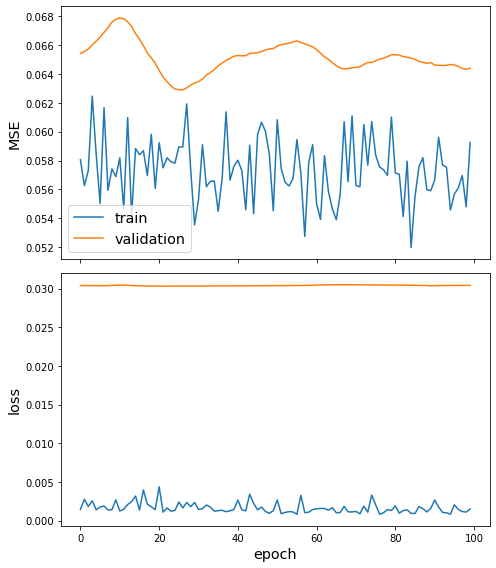

In [38]:
train_pred, test_pred, test_true = forecasting(trainX, trainY, testX, testY, train_data)

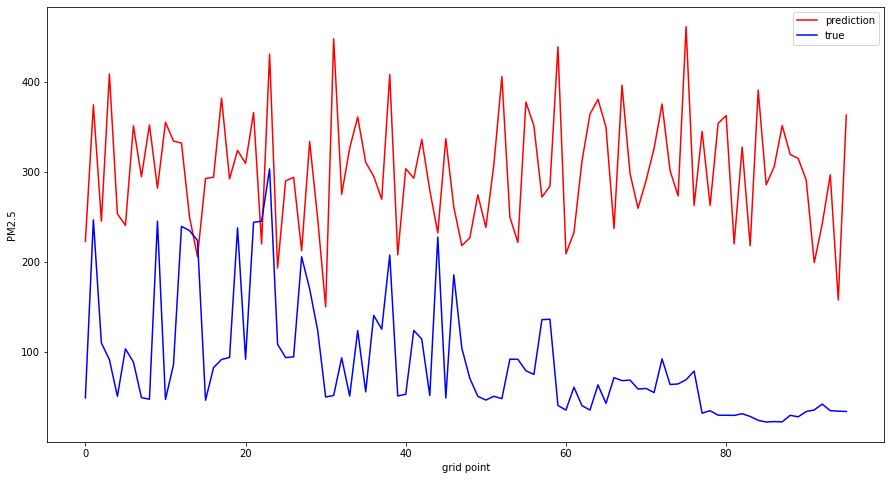

In [35]:
#all test result visualization
fig1 = plt.figure(figsize=(15, 8))
a_pred = test_pred[test_pred>0]
a_true = test_true[test_true>0]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("grid point")
plt.ylabel("PM2.5")
plt.legend(loc="best", fontsize=10)
plt.show()

54650
54649
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  1.1752764294215012e-05 
Test loss: 0.0011542048305273056
1/1 [==============================] - 0s 143ms/step
RMSE loss:  tf.Tensor(24.100682146325354, shape=(), dtype=float64)


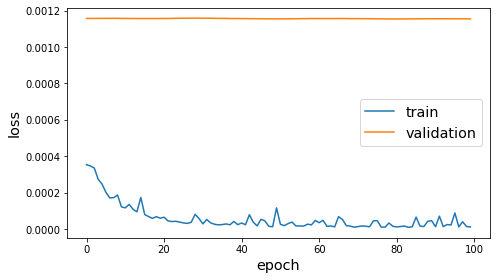

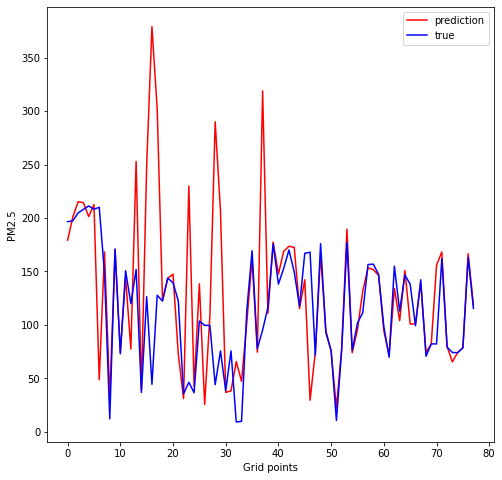

21113
21112
96213
96155
81079
81079
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  1.9766983314184472e-05 
Test loss: 0.00028135674074292183
1/1 [==============================] - 0s 142ms/step
RMSE loss:  tf.Tensor(28.761026455791768, shape=(), dtype=float64)


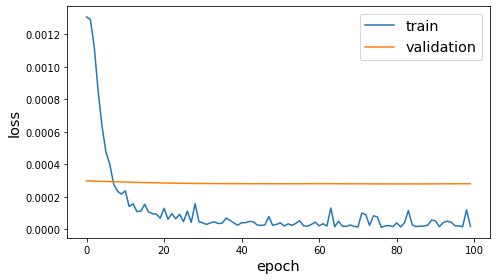

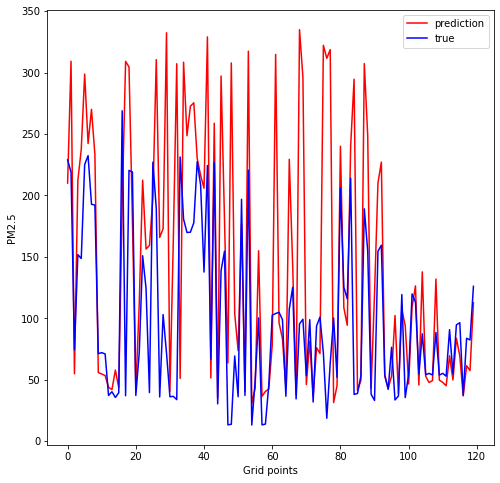

5348
5348
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  8.48017316457117e-06 
Test loss: 0.0002534900268074125
1/1 [==============================] - 0s 141ms/step
RMSE loss:  tf.Tensor(6.950489416024729, shape=(), dtype=float64)


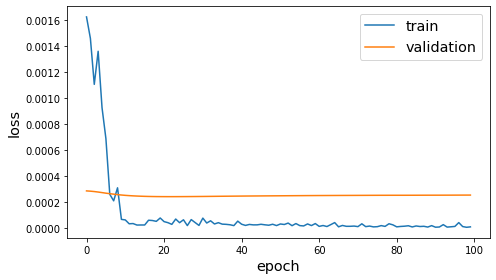

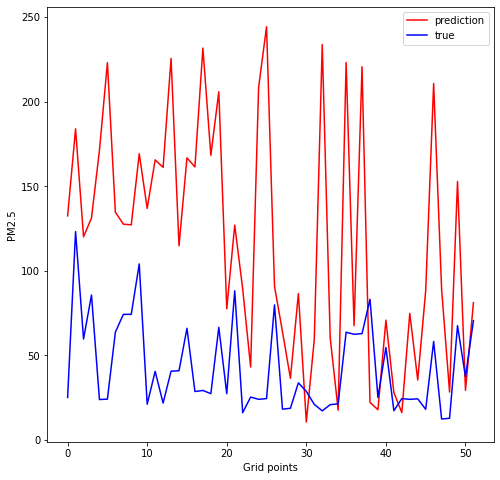

6992
6992
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  5.3839867177885026e-06 
Test loss: 0.00034699542447924614
1/1 [==============================] - 0s 145ms/step
RMSE loss:  tf.Tensor(8.473735316002438, shape=(), dtype=float64)


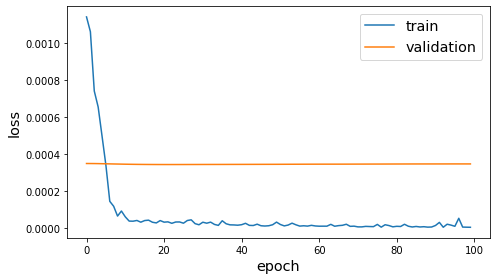

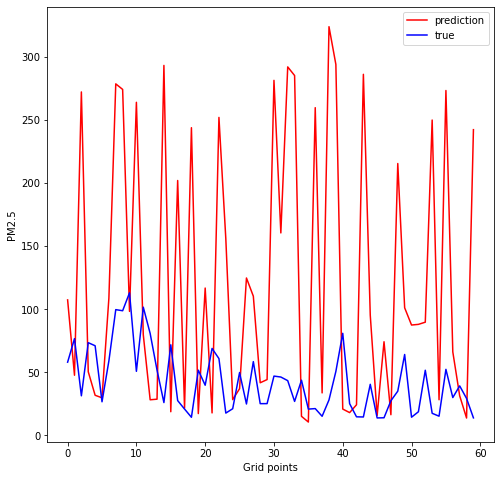

2606
2606
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  3.7513159441004973e-06 
Test loss: 4.99857596878428e-05
1/1 [==============================] - 0s 143ms/step
RMSE loss:  tf.Tensor(4.255632806394813, shape=(), dtype=float64)


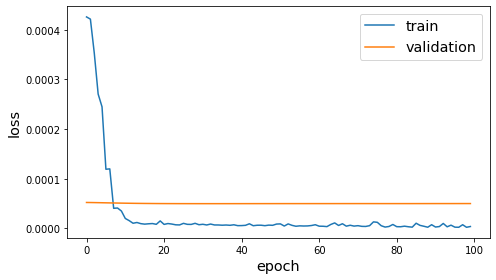

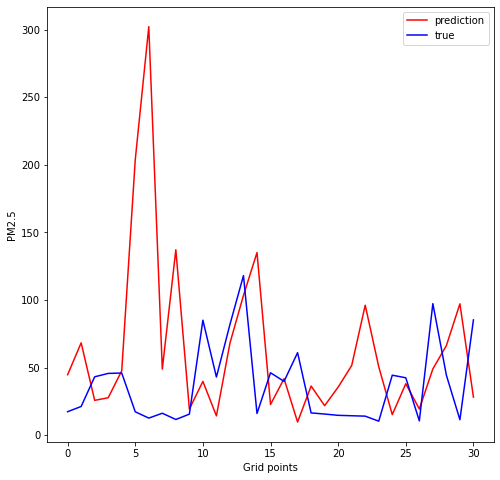

2473
2473
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  8.315922059409786e-06 
Test loss: 0.0001179361279355362
1/1 [==============================] - 0s 142ms/step
RMSE loss:  tf.Tensor(6.363966012873704, shape=(), dtype=float64)


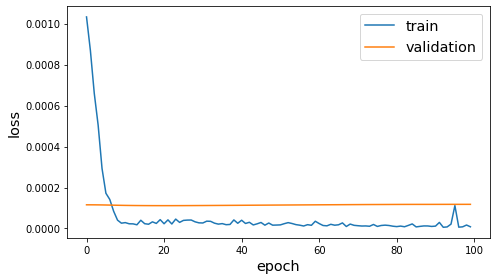

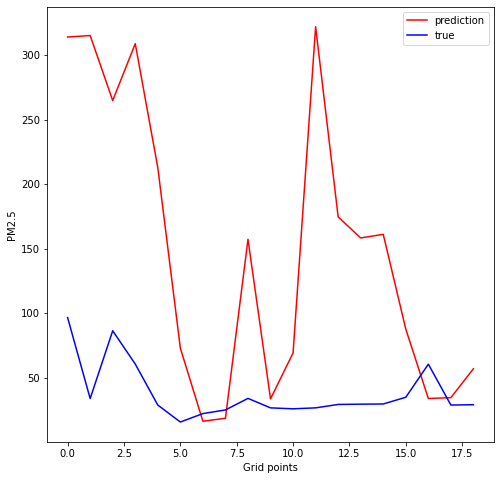

4652
4652
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  1.8476202967576683e-05 
Test loss: 4.601716864272021e-05
1/1 [==============================] - 0s 141ms/step
RMSE loss:  tf.Tensor(11.611036618512346, shape=(), dtype=float64)


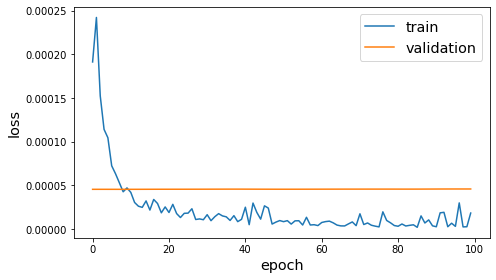

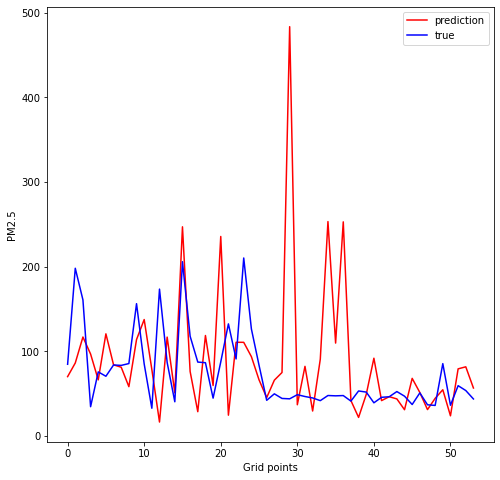

2127
2127
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  3.590098913264228e-06 
Test loss: 0.0001585911522852257
1/1 [==============================] - 0s 142ms/step
RMSE loss:  tf.Tensor(6.140257331375191, shape=(), dtype=float64)


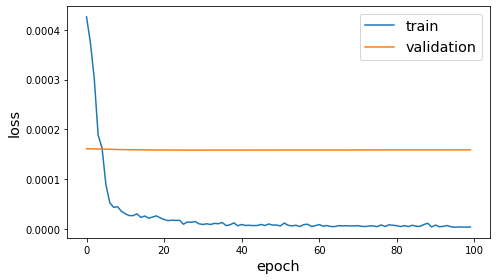

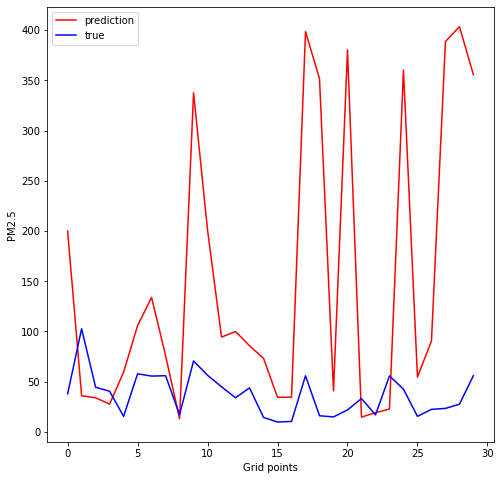

38641
38641
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  2.277566454722546e-05 
Test loss: 0.0005922812270000577
1/1 [==============================] - 0s 145ms/step
RMSE loss:  tf.Tensor(9.1300885398136, shape=(), dtype=float64)


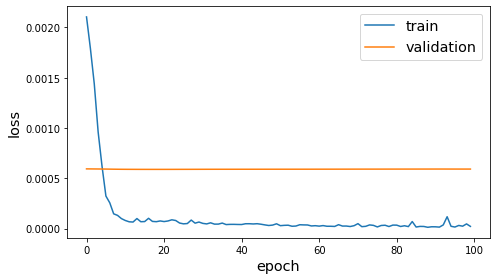

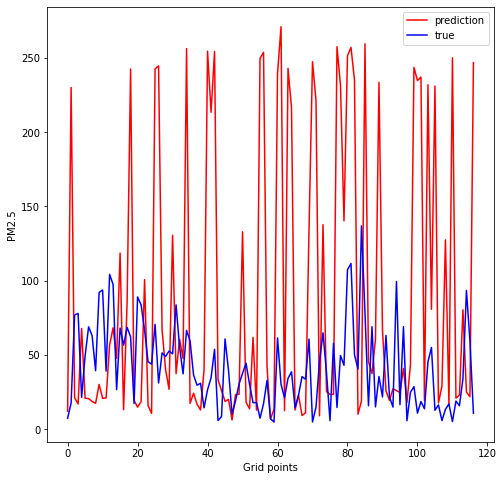

83960
83959
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  0.00011559657286852598 
Test loss: 0.0001786043867468834
1/1 [==============================] - 0s 202ms/step
RMSE loss:  tf.Tensor(17.98565014180433, shape=(), dtype=float64)


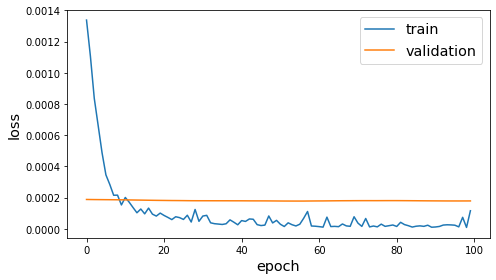

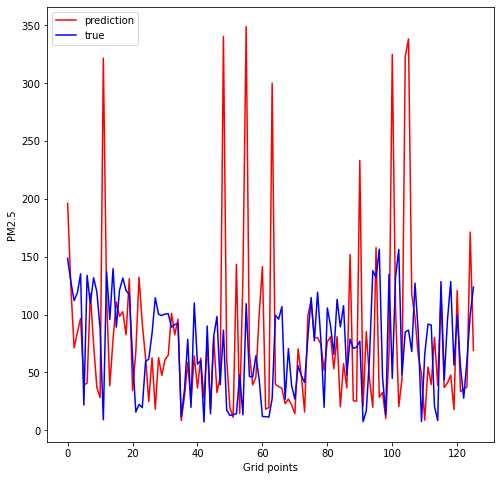

156879
156878
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  2.6386338504380547e-05 
Test loss: 0.00024561770260334015
1/1 [==============================] - 0s 167ms/step
RMSE loss:  tf.Tensor(25.914221416815554, shape=(), dtype=float64)


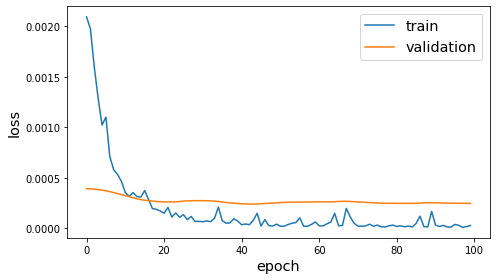

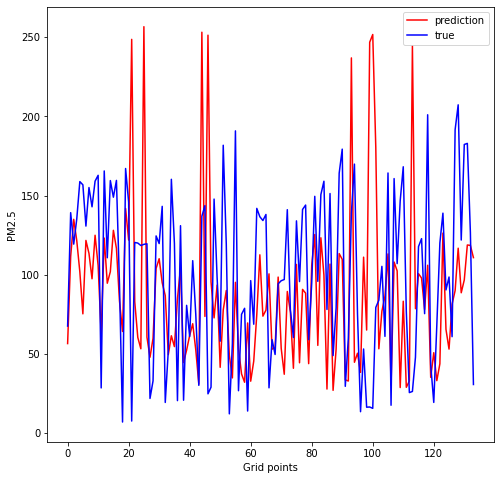

66662
66637
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  7.296125659195241e-06 
Test loss: 0.0003789519832935184
1/1 [==============================] - 0s 176ms/step
RMSE loss:  tf.Tensor(34.25968138004225, shape=(), dtype=float64)


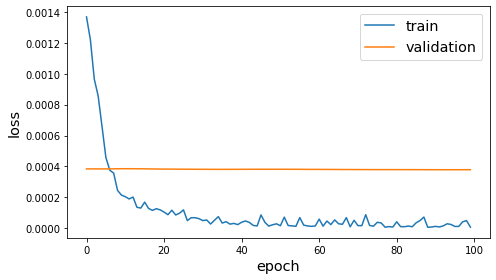

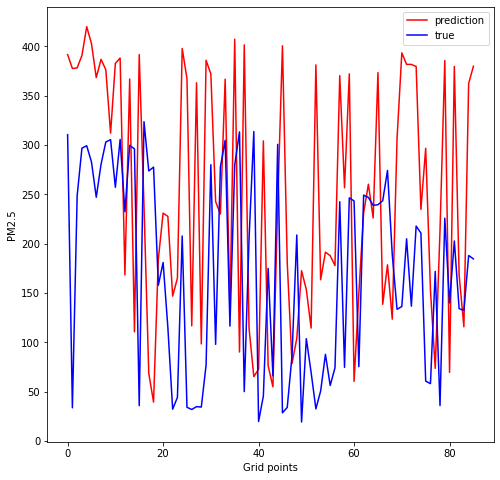

181056
181055
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  1.0074678357341327e-05 
Test loss: 0.0001932248123921454
1/1 [==============================] - 0s 173ms/step
RMSE loss:  tf.Tensor(30.136074607519564, shape=(), dtype=float64)


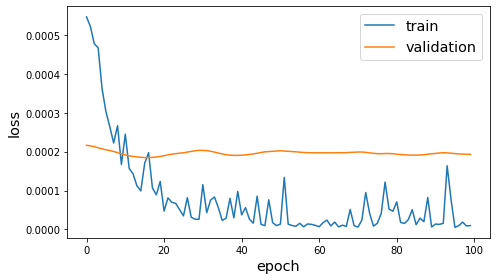

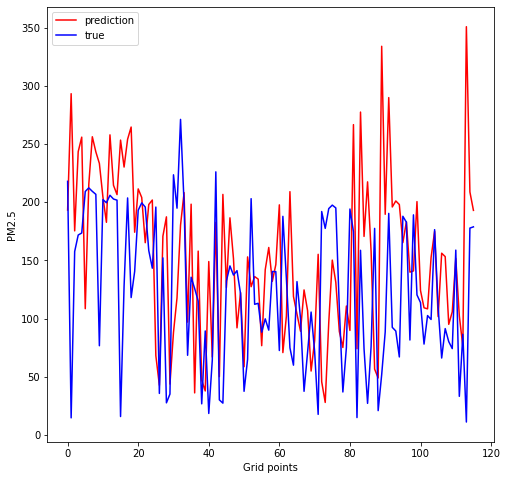

173485
173481
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  5.914688699704129e-06 
Test loss: 8.281468035420403e-05
1/1 [==============================] - 0s 190ms/step
RMSE loss:  tf.Tensor(12.603369871718801, shape=(), dtype=float64)


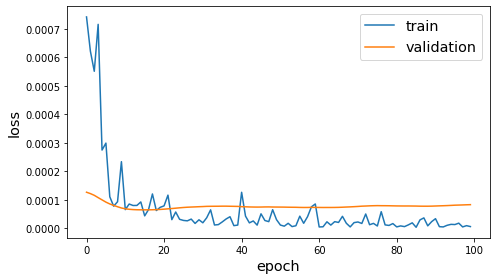

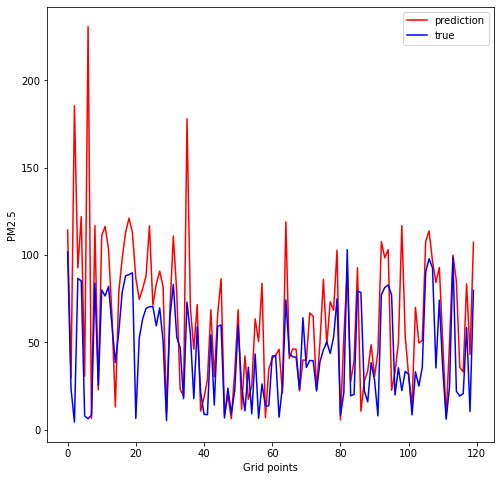

174180
174170
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  2.033709461102262e-05 
Test loss: 0.0004248540208209306
1/1 [==============================] - 0s 149ms/step
RMSE loss:  tf.Tensor(11.152693135413852, shape=(), dtype=float64)


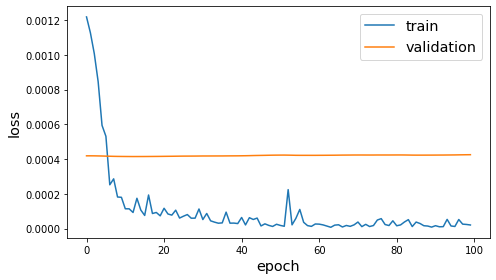

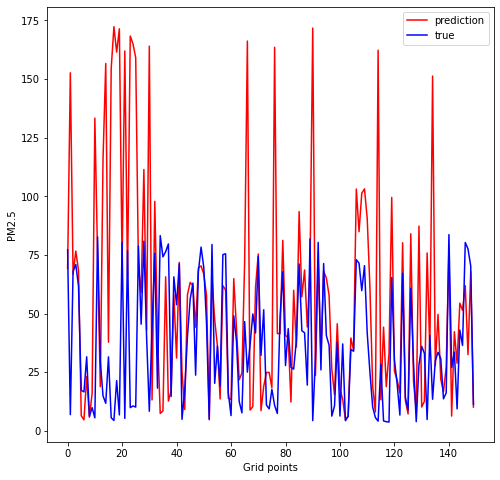

152868
152868
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  7.873714821471367e-06 
Test loss: 4.1339113522553816e-05
1/1 [==============================] - 0s 165ms/step
RMSE loss:  tf.Tensor(16.68178215176275, shape=(), dtype=float64)


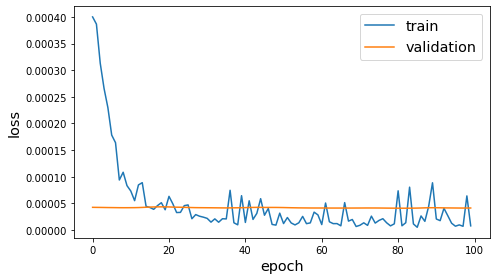

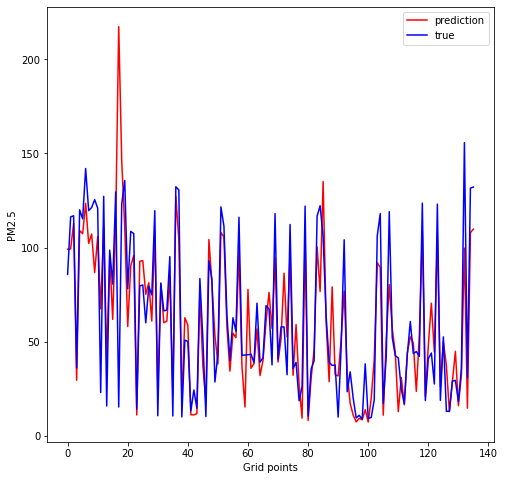

146620
146619
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  8.800662726571318e-06 
Test loss: 0.0001940878137247637
1/1 [==============================] - 0s 140ms/step
RMSE loss:  tf.Tensor(18.890052467235186, shape=(), dtype=float64)


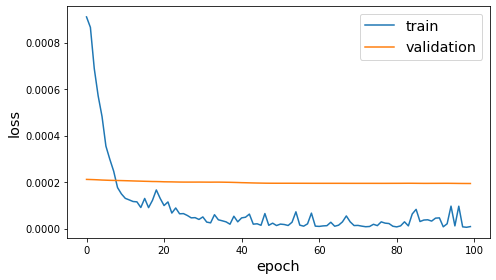

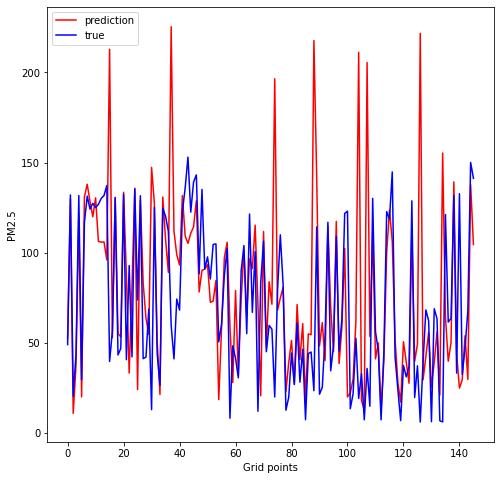

149311
149301
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  1.867487844720017e-05 
Test loss: 5.7912628108169883e-05
1/1 [==============================] - 0s 196ms/step
RMSE loss:  tf.Tensor(20.705938509885915, shape=(), dtype=float64)


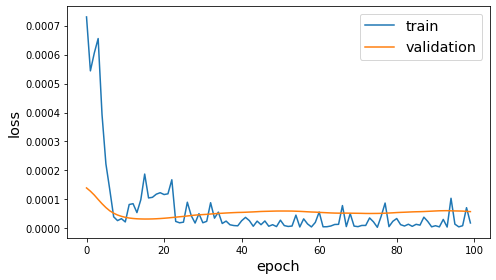

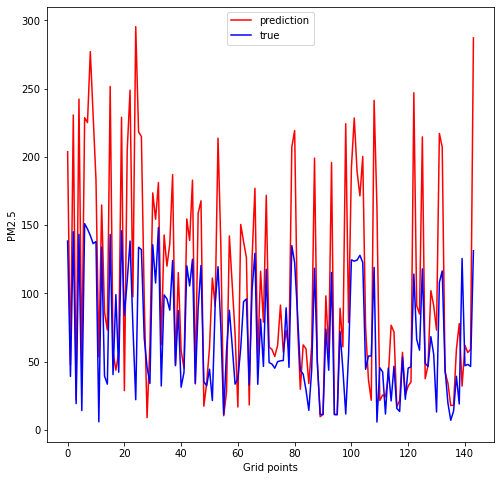

143593
143592
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  5.436102583189495e-06 
Test loss: 0.00010431260307086632
1/1 [==============================] - 0s 172ms/step
RMSE loss:  tf.Tensor(16.152162267943815, shape=(), dtype=float64)


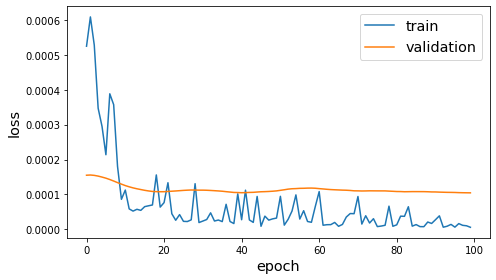

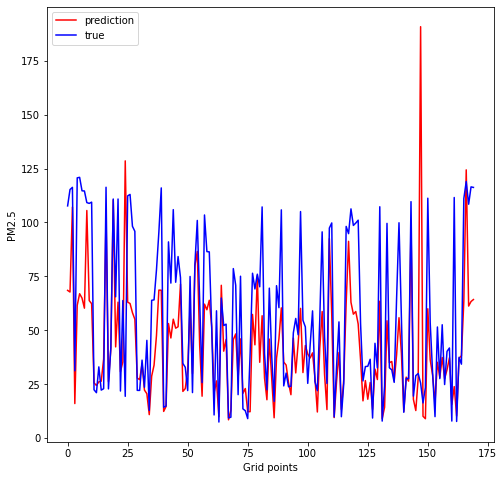

130109
130102
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  4.402521881274879e-05 
Test loss: 2.5591383746359497e-05
1/1 [==============================] - 0s 174ms/step
RMSE loss:  tf.Tensor(18.280141158167215, shape=(), dtype=float64)


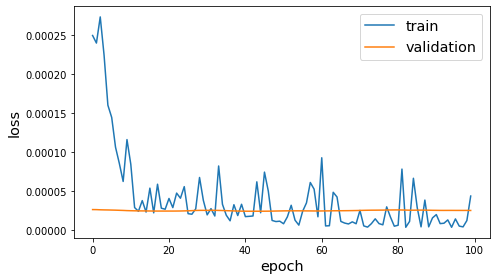

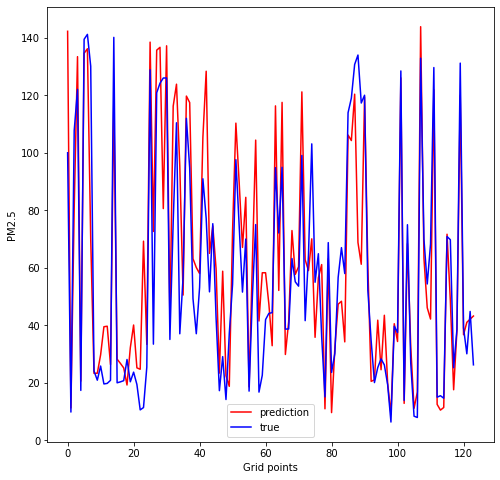

96426
96409
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  6.622492946917191e-05 
Test loss: 0.00048664791393093765
1/1 [==============================] - 0s 171ms/step
RMSE loss:  tf.Tensor(20.347927485791566, shape=(), dtype=float64)


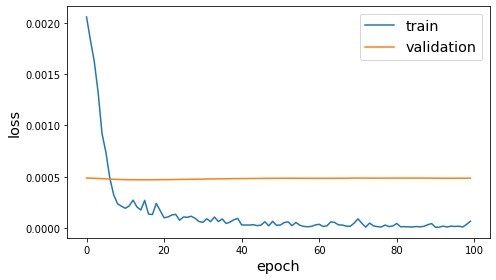

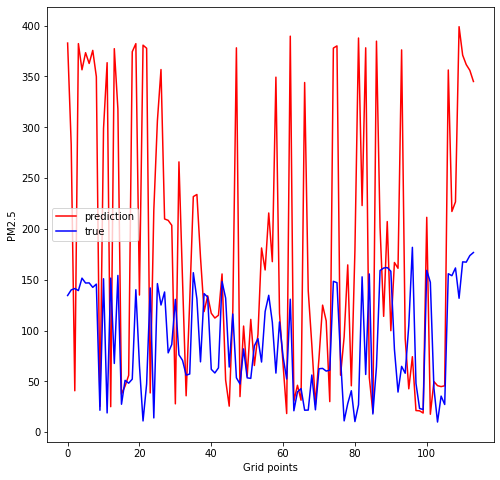

33732
33731
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  2.58163049693394e-06 
Test loss: 5.635794877889566e-05
1/1 [==============================] - 0s 193ms/step
RMSE loss:  tf.Tensor(16.19353244150742, shape=(), dtype=float64)


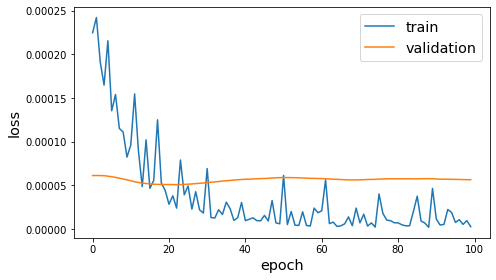

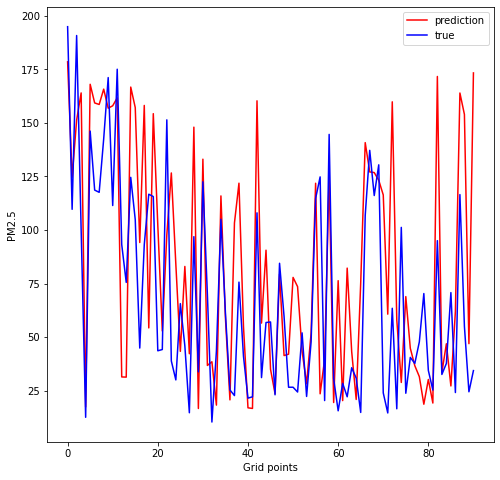

45730
45730
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  3.378498149686493e-05 
Test loss: 0.00014109123731032014
1/1 [==============================] - 0s 171ms/step
RMSE loss:  tf.Tensor(20.122497611466827, shape=(), dtype=float64)


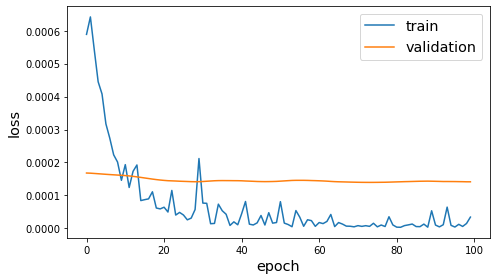

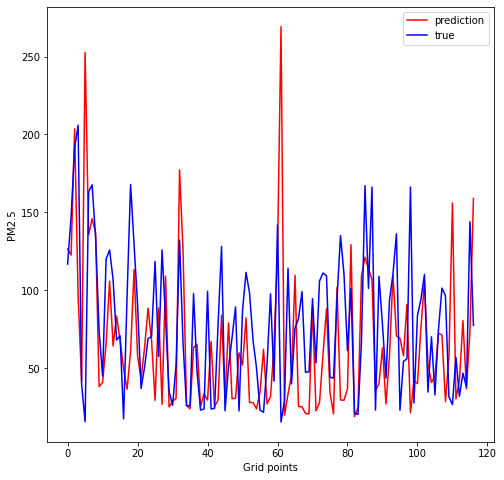

29321
29291
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  1.5857407333896845e-06 
Test loss: 0.00010693831427488476
1/1 [==============================] - 0s 188ms/step
RMSE loss:  tf.Tensor(6.756982206659378, shape=(), dtype=float64)


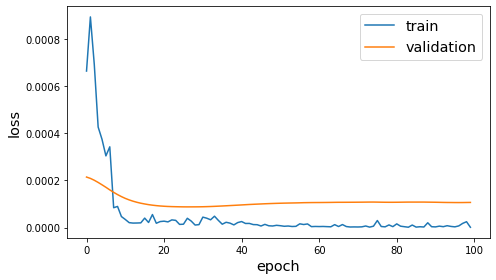

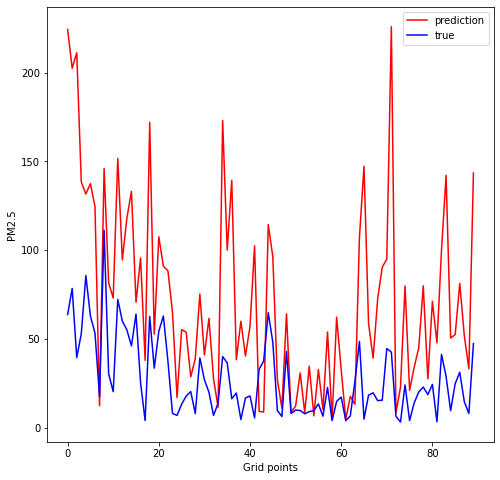

53425
53423
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  7.1846097853267565e-06 
Test loss: 6.772448250558227e-05
1/1 [==============================] - 0s 169ms/step
RMSE loss:  tf.Tensor(7.14157686671989, shape=(), dtype=float64)


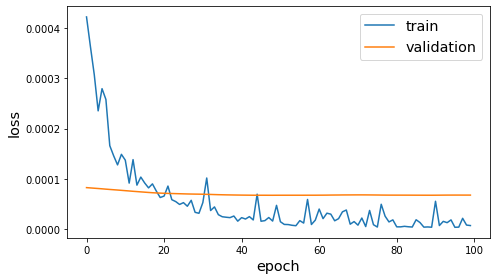

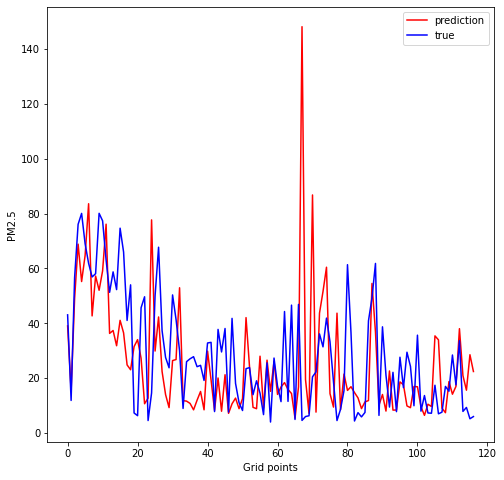

48393
48392
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  2.3577358660986647e-05 
Test loss: 0.0004991322639398277
1/1 [==============================] - 0s 173ms/step
RMSE loss:  tf.Tensor(8.278014612418037, shape=(), dtype=float64)


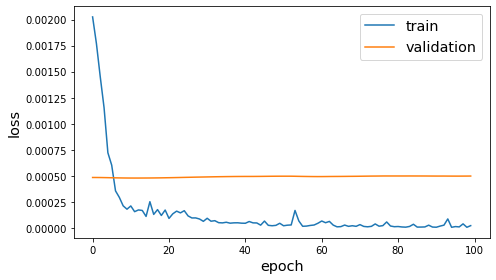

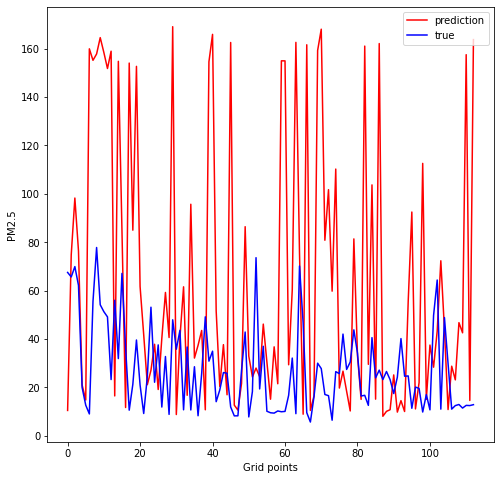

45290
45135
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  1.1118704605905805e-05 
Test loss: 0.0005060093244537711
1/1 [==============================] - 0s 172ms/step
RMSE loss:  tf.Tensor(10.119733226400946, shape=(), dtype=float64)


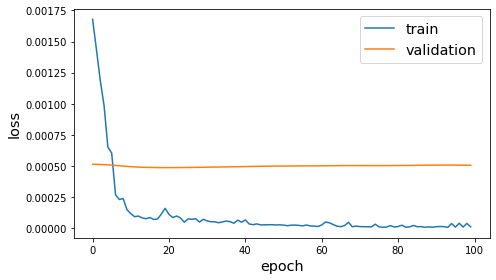

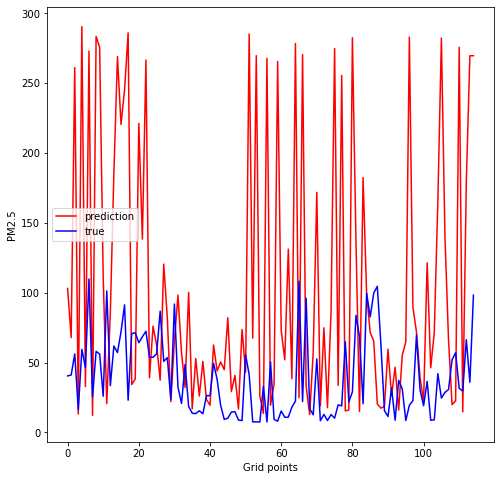

61393
61393
Train data:  (10201, 12)
Test data:  (10201, 12)
(1, 10201, 12)
(1, 10201)
(1, 10201, 12)
(1, 10201)
Train loss:  3.6400258977664635e-05 
Test loss: 0.00017504472634755075
1/1 [==============================] - 0s 150ms/step
RMSE loss:  tf.Tensor(18.53076868266623, shape=(), dtype=float64)


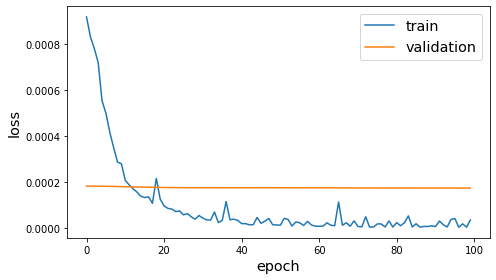

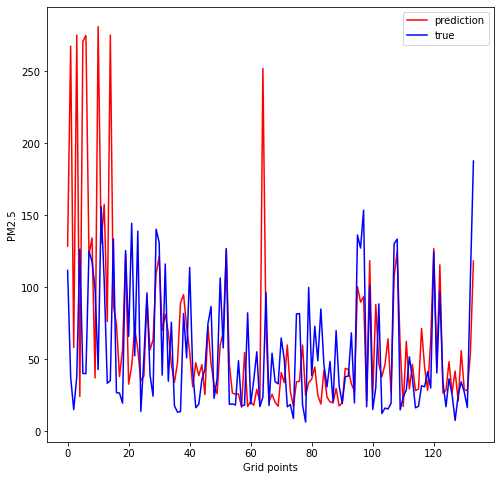

In [27]:
for i in range(1, 31):

    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    df = datapreparation(datafile)
    if(df.shape[1]) != 12:
        continue
    trainX, trainY, testX, testY, train_data = prepare_train_data(df, train_rate)
    train_rescpred, test_rescpred, test_rescref = forecasting(trainX, trainY, testX, testY, train_data)

    ##all test result visualization
    fig1 = plt.figure(figsize=(8, 8))
    #    ax1 = fig1.add_subplot(1,1,1)
    a_pred = test_rescpred[test_rescpred>0]
    a_true = test_rescref[test_rescref>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("Grid points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    plt.show()